# CellPLM

CellPLM is the first single-Cell Pre-trained Language Model that encodes cell-cell relations and it consistently outperforms existing pre-trained and non-pre-trained models in diverse downstream tasks, with 100x higher inference speed compared to existing pre-trained models.

Here, you can use `omicverse.llm.SCLLMManager(model_type="cellplm")` to call this model directly.

Cite: Wen, H., Tang, W., Dai, X., Ding, J., Jin, W., Xie, Y., & Tang, J. (2023). CellPLM: Pre-training of cell language model beyond single cells. BioRxiv, 2023-10.

In [1]:
import scanpy as sc
import omicverse as ov
ov.plot_set(font_path='Arial')

# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

🔬 Starting plot initialization...
Arial font downloaded successfully to: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA H100 80GB HBM3
    • Total memory: 79.1 GB
    • Compute capability: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## Load example datasets

For this tutorial, we use three batches from the NeurIPS 2021 single-cell competition dataset, which provides an excellent test case for batch integration and cell type annotation.

- s1d3: https://figshare.com/ndownloader/files/41932005
- s2d1: https://figshare.com/ndownloader/files/41932011
- s3d7: https://figshare.com/ndownloader/files/41932008

In [2]:
adata1=ov.read('data/neurips2021_s1d3.h5ad')
adata1.obs['batch']='s1d3'
adata2=ov.read('data/neurips2021_s2d1.h5ad')
adata2.obs['batch']='s2d1'
adata3=ov.read('data/neurips2021_s3d7.h5ad')
adata3.obs['batch']='s3d7'

In [3]:
adata=sc.concat([adata1,adata2,adata3],merge='same')
adata

AnnData object with n_obs × n_vars = 27423 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [ ]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',
                       n_HVGs=3000,batch_key=None,target_sum=1e4)
adata

In [6]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs × n_vars = 27423 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Initialize CellPLM model

CellPLM requires pre-trained model checkpoints that contain the transformer weights and tokenization vocabulary. The model supports multiple pipeline tasks including embedding extraction, cell type annotation, and data imputation.

Download the CellPLM model from:: https://www.dropbox.com/scl/fo/i5rmxgtqzg7iykt2e9uqm/h/ckpt?dl=0&subfolder_nav_tracking=1

In [4]:
manager = ov.llm.SCLLMManager(
    model_type="cellplm",
    model_path="llm_model/models/cellplm",
    pretrain_version="20231027_85M"
)

📥 Loading CellPLM model from llm_model/models/cellplm...


Loading imputation pipeline...: 100%|█████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]

[Loaded]  CellPLM model loaded from llm_model/models/cellplm
    - Loaded pipelines: annotation, embedding, imputation
    - Pretrain version: 20231027_85M


## Zero-shot embedding generation

Zero-shot embedding leverages CellPLM's pre-trained knowledge to generate meaningful cell representations without any dataset-specific training.

The 512-dimensional embeddings provide a compressed but information-rich representation of each cell's transcriptional state.

In [7]:
embeddings = manager.get_embeddings(adata)

[🔬Cells] Data Summary:
    Cells: 27,423
    Genes: 3,000
    Batches: 3
      s3d7: 11,230 cells
      s2d1: 10,258 cells
      s1d3: 5,935 cells
[Embedding] Starting get_embeddings...
    cells: 27,423
    genes: 3,000
    [Embedding] Extracting embeddings for 27,423 cells...


[CellPLM] Computing embeddings...:   0%|          | 0/2 [00:00<?, ?it/s]

Automatically converting gene symbols to ensembl ids...


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
53 input query terms found dup hits:	[('LINC00115', 2), ('TNFRSF14-AS1', 3), ('CCDC18-AS1', 2), ('LINC00623', 2), ('LINC02591', 2), ('TMC
292 input query terms found no hit:	['AL139246.5', 'AL021155.5', 'BX284668.5', 'BX284668.6', 'AL020997.5', 'AL360012.1', 'AC004865.2', '


After filtering, 2339 genes remain.


[✅Complete] get_embeddings completed successfully!
[✅Complete] Results summary:
    embedding_shape: (27423, 512)
    embedding_dim: 512


In [11]:
embeddings.shape

(27423, 512)

embedding: (27423, 512)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:17)


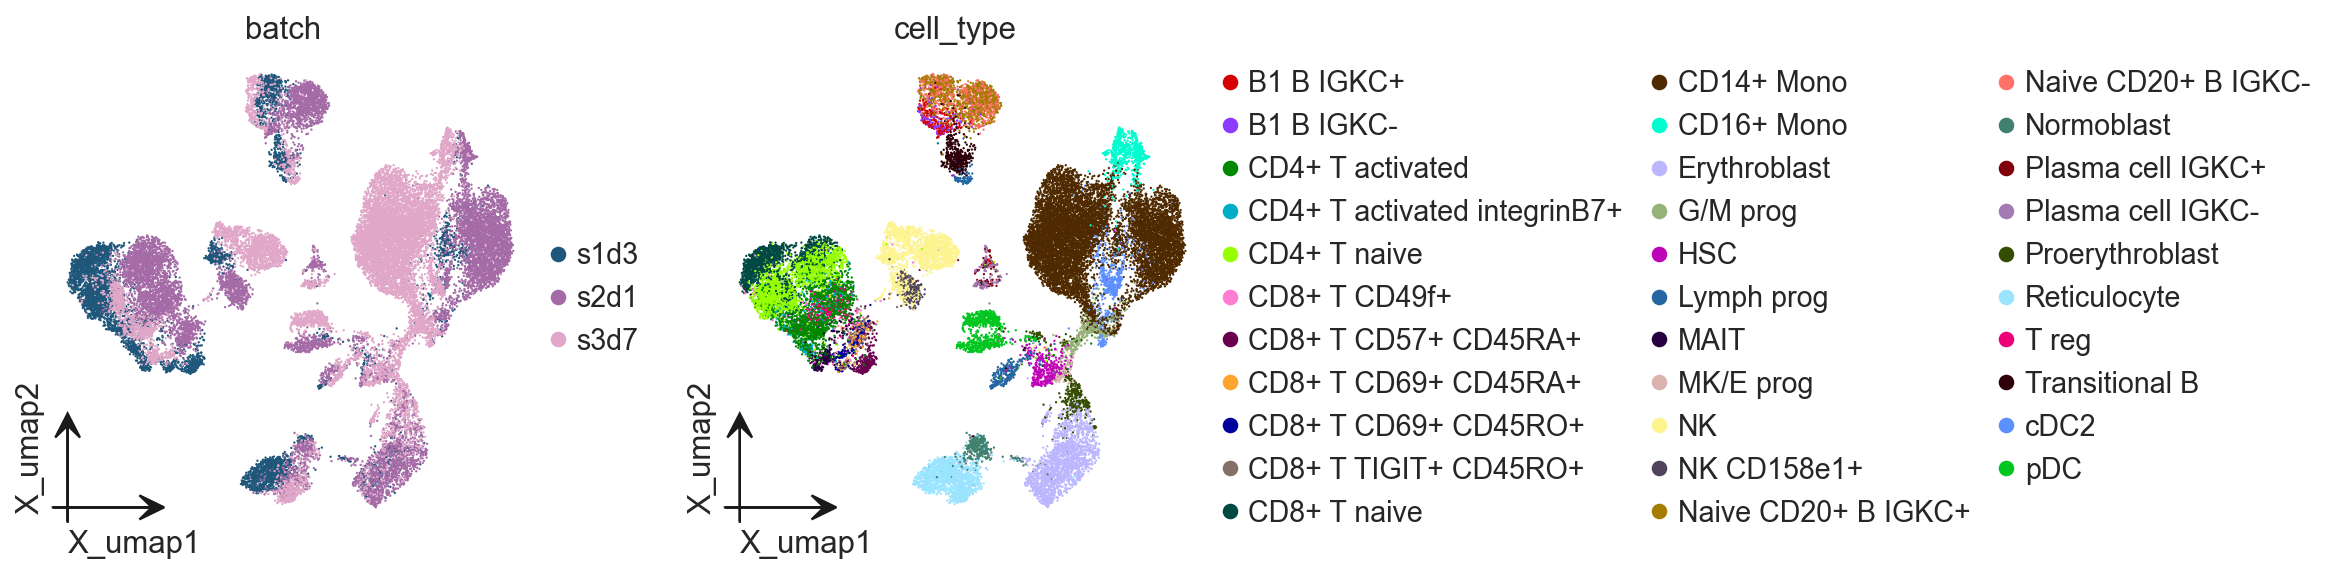

In [12]:
print(f"embedding: {embeddings.shape}")

adata.obsm['X_cellplm'] = embeddings

sc.pp.neighbors(adata, use_rep='X_cellplm')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

## Fine-tuning for enhanced performance

Fine-tuning adapts CellPLM's pre-trained weights to the specific characteristics of our dataset, significantly improving performance on downstream tasks. This supervised learning approach uses high-quality cell type annotations from the reference batch (s1d3) to:

In [13]:
reference_adata=adata[adata.obs['batch']=='s1d3']

In [14]:
reference_adata.obs['celltype']=reference_adata.obs['cell_type'].copy()

In [33]:
fine_tune_results = manager.model.fine_tune(
    train_adata=reference_adata,
    epochs=1500,           # 
    batch_size=32,       # 
    lr=1e-4,            # 
)

🚀 Starting CellPLM fine-tuning for annotation task...
Training parameters: epochs=500, batch_size=32, lr=0.0001
📊 Preparing cell type mapping...


Data preparation: 100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 4482.69it/s]


Found 30 cell types: ['B1 B IGKC+', 'B1 B IGKC-', 'CD4+ T activated', 'CD4+ T activated integrinB7+', 'CD4+ T naive', 'CD8+ T CD49f+', 'CD8+ T CD57+ CD45RA+', 'CD8+ T CD69+ CD45RA+', 'CD8+ T CD69+ CD45RO+', 'CD8+ T TIGIT+ CD45RO+', 'CD8+ T naive', 'CD14+ Mono', 'CD16+ Mono', 'Erythroblast', 'G/M prog', 'HSC', 'Lymph prog', 'MAIT', 'MK/E prog', 'NK', 'Naive CD20+ B IGKC+', 'Naive CD20+ B IGKC-', 'Normoblast', 'Plasma cell IGKC+', 'Proerythroblast', 'Reticulocyte', 'T reg', 'Transitional B', 'cDC2', 'pDC']
🔄 Preparing training and validation data...


Splitting data: 100%|████████████████████████████████████████████████| 3/3 [00:00<00:00, 257.23it/s]

Split data: 4748 train, 1187 validation



INFO:biothings.client:querying 1-1000 ...


🏋️ Starting training with CellPLM pipeline...
📈 Training for 500 epochs with real-time metrics...


INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
100%|██████████| 500/500 [01:16<00:00,  6.57it/s]


After filtering, 2339 genes remain.

📊 Final Training Results (Epoch 499):
   🎯 Train ACC: 0.7077
   ✅ Valid ACC: 0.6934
   📈 Train F1:  0.7066
   📈 Valid F1:  0.6846
✓ CellPLM annotation fine-tuning completed successfully!


### Batch integration with fine-tuned model

After fine-tuning, we perform batch integration to remove technical variations while preserving biological differences. This critical step ensures that cells from different batches can be properly compared and analyzed together.

In [34]:
zero_shot_results = manager.model.integrate(
    adata,
    batch_key="batch",
    correction_method="mnn",
)
adata.obsm['X_cellplm_fine'] = zero_shot_results['embeddings']

🔗 Performing batch integration for 27423 cells...
🧬 Extracting embeddings for 27423 cells...


Computing embeddings...:   0%|                                                | 0/2 [00:00<?, ?it/s]WARNING:biothings.client:Input sequence provided is already in string format. No operation performed
INFO:biothings.client:querying 1-1000 ...


Automatically converting gene symbols to ensembl ids...


INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


After filtering, 2339 genes remain.


Applying mnn correction...:   0%|                                             | 0/2 [00:00<?, ?it/s]

   Applying MNN correction...


Finalizing integration...: 100%|██████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s]

     MNN correction applied to 3 batches


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:17)


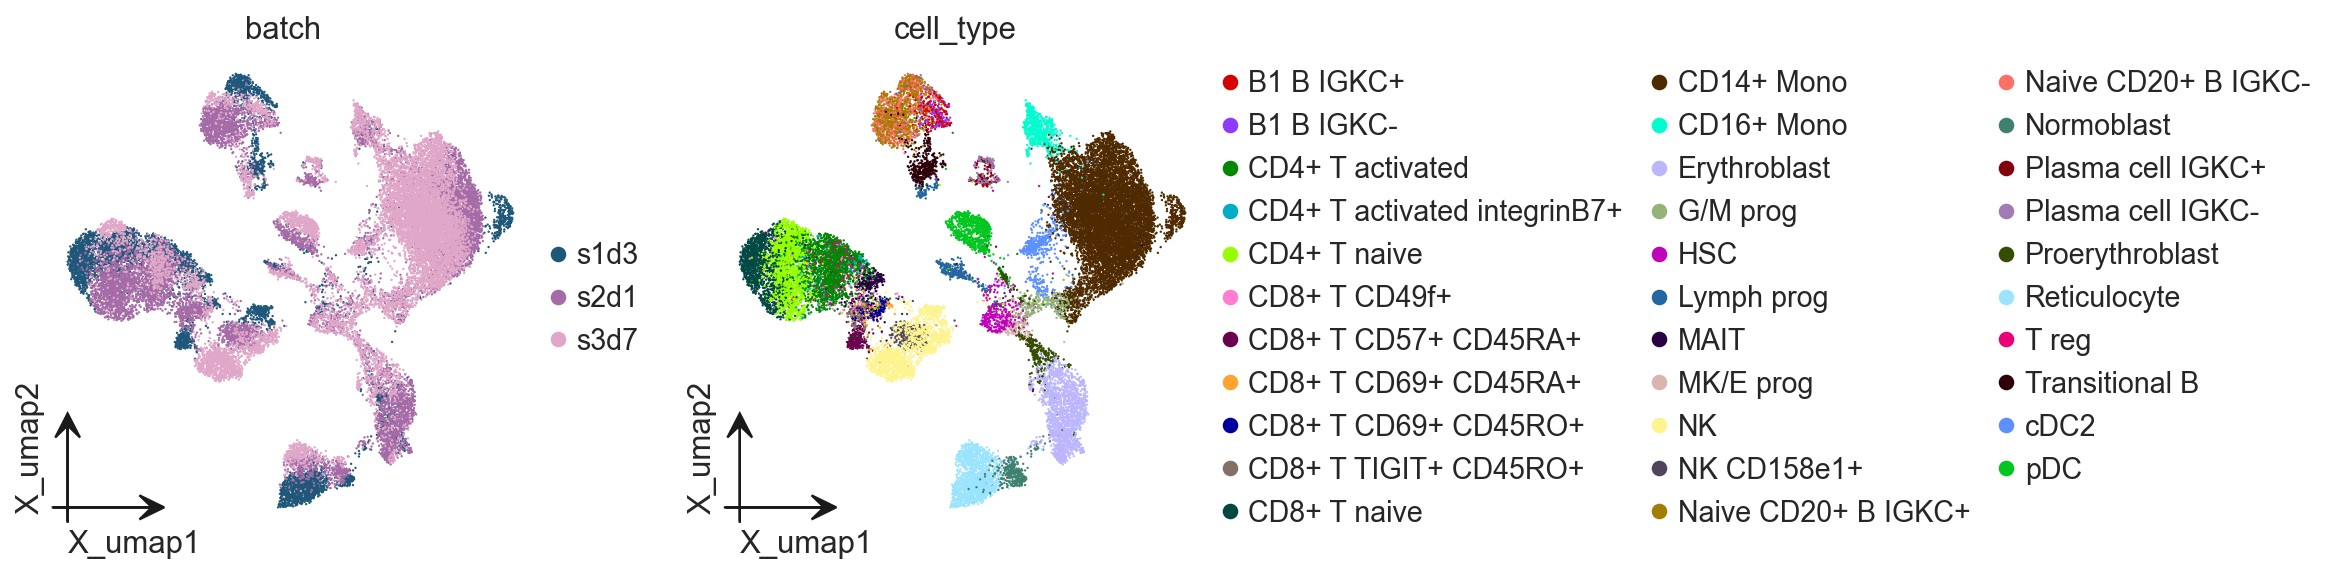

In [35]:
sc.pp.neighbors(adata, use_rep='X_cellplm_fine')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

### Cell type annotation with fine-tuned model

The fine-tuned CellPLM model can now predict cell types for all cells in the dataset, including those from batches not used in training. This demonstrates the model's ability to generalize learned patterns to new data while leveraging the improved discrimination capability gained through fine-tuning.

In [36]:
prediction_results = manager.model.predict_celltypes(
    adata,
)

adata.obs['predicted_celltype'] = prediction_results['predicted_celltypes']
adata.obs['predicted_celltype_id'] = prediction_results['predictions']

🔮 Predicting cell types for 27423 cells...


Running prediction...:   0%|                                                  | 0/2 [00:00<?, ?it/s]WARNING:biothings.client:Input sequence provided is already in string format. No operation performed
INFO:biothings.client:querying 1-1000 ...


Automatically converting gene symbols to ensembl ids...


INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


After filtering, 2339 genes remain.


Processing results...: 100%|██████████████████████████████████████████| 2/2 [00:11<00:00,  5.85s/it]


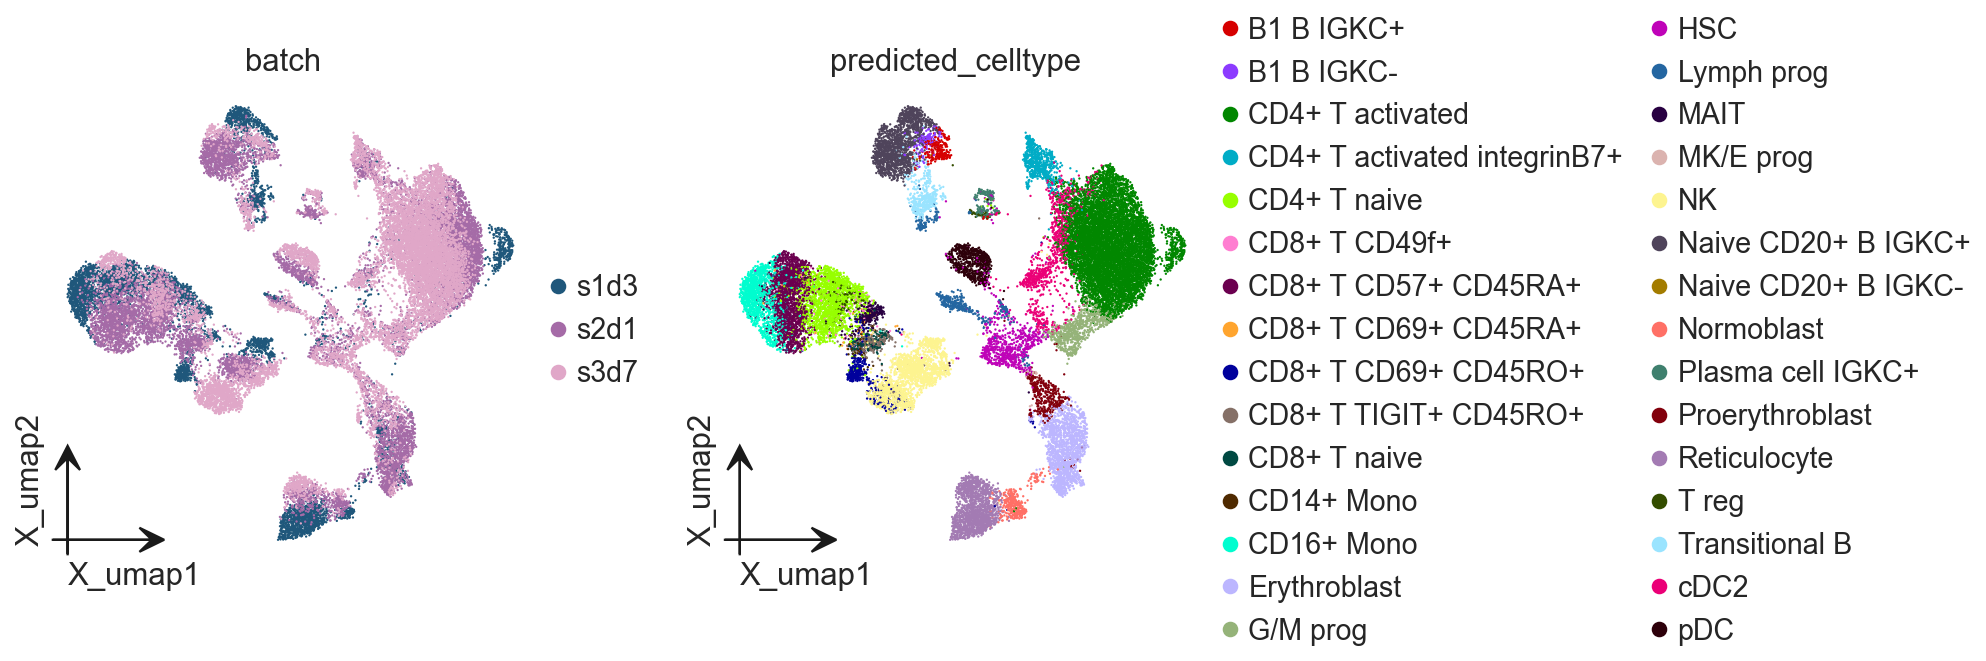

In [37]:
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'predicted_celltype']
)